# Step 1 - Mount drive
Mount your google drive which has the training, test and dev jsonlfiles and labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/NLP_data

/content/drive/My Drive/NLP_data


In [ ]:
%ls

couchdb_local.json
dev.baseline1.json
dev.baseline_bert2.json
dev.baseline_bert6.json
dev.baseline_bertF11.json
dev.baseline_bertF1.json
dev.data.jsonl
dev.label.json
finetuned_BERT_epoch_0_seed42_new.model
finetuned_BERT_epoch_1_seed42_new.model
finetuned_BERT_epoch_2_seed42_new.model
firstthree.jsonl
sstcls_0.dat
sstcls_3.dat
sstcls_6.dat
test.baseline_bertF1.json
test.data.jsonl
train.data.jsonl
train.label.json


# Step 2 - Setup

## 1. Load Essential Libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import collections
import json
from sklearn import preprocessing

%matplotlib inline

# 2. Load Dataset

In [ ]:
#function to return the replies as a list for a source tweet 
def get_replies(df):
    dict_time = {}
    # rows = df.loc["Utah Jazz"]
    for index, row in df.iterrows():
        #check if the in_reply_to_status_id_str string matches a number
        x = re.search(r'\d+', str(row['in_reply_to_status_id_str']))  
        if x:
            
            #append the reply tweets in a big_list and return the list
            big_list.append(row["tweet"]) 
            #if the tweets are created at the same time - append it to existing list
            if (row["created_at"] in dict_time):
                # print("True")
                value = dict_time.get(row["created_at"])
                value.append(row["tweet"])
                dict_time[row["created_at"]] = value
                # print(replyTw_list)
            else:
                replyTw_list = []
                replyTw_list.append(row["tweet"])
                # print(replyTw_list) 
                dict_time[row["created_at"]] = replyTw_list
            # print(dict_time)
        else:
            big_list = []
    #returns the list of replies for a source tweet, length of the reply list and dict of {created_at_Time:reply_tweet}
    # print(big_list, dict_time)
    return big_list,len(big_list),dict_time 
#function to return the list of reply tweets sorted by time for all source tweets
#takes the list of dictionaries as a parameter of the form [{created_At_time1:[tweet1, tweet2]},{created_At_time2:[tweet3]}]
def get_sorted_by_time(dict_replies_list):
    sorted_list = []
    for i in range(len(dict_replies_list)):
        # dtime = 'Mon Dec 15 21:50:30 +0000 2014'
        newkeys_list = []
        for k, v in dict_replies_list[i].items():  
            new_datetime = datetime.strftime(datetime.strptime(k,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S') 
            date_to_float = datetime.fromisoformat(new_datetime).timestamp()#1420646211.0
            newkeys_list.append(date_to_float) #list of keys for the new dictionary 
            vals = list(dict_replies_list[i].values()) #list of values for the new dictionary 
        newdictionary = {k: v for k, v in zip(newkeys_list, vals)} #zip the keys and values to form a new dictionary 
        od = collections.OrderedDict(sorted(newdictionary.items()))
#         print("DICT KEYS AFTER SORtiNG:\n", od.keys(), len(od))
#         print("DICT KEYS AFTER SORtiNG:\n", newdictionary.keys(), len(newdictionary),"\n Values:\n",newdictionary.values())
        sorted_list.append(od)
    # print("The length of sorted list is = ", len(sorted_list))
    return sorted_list

In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 500)
with open("train.data.jsonl", 'r', encoding='utf-8') as train_data_file:
  list_of_rlists = []
  chunks = [] #list of all the dataframes for all source and reply tweets
  num_replies = [] #list of number of replies for every source tweet 
  dict_replies= {} #dict of {created_At_time:[reply tweet]} for every source tweet
  list_replies = []
  dict_replies_list = []
  for line in train_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)

    replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
    replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
    # print(len(replies_list_2d))
    replies_list_1d = [j for sub in replies_list_2d for j in sub]
    # print(len(replies_list_1d))
    reply_length = len(replies_list_1d)
    list_replies.append(reply_length) 
    dict_replies_list.append(dict_replies)

    chunks.append(df)
    list_of_rlists.append(replies_list)
    num_replies.append(len_reply_list)
    # print("The output of list_of_rlists in every iteration=",list_of_rlists,"\n",len(list_of_rlists))
  dfs1 = pd.concat(chunks)
train_data_file.close()
#print(dfs1)
# print("The len of list of list of replies=", len(list_of_rlists))


with open("train.label.json") as train_label_file:
    train_label_json_file = json.load(train_label_file)
    df_train_label = pd.DataFrame(list(train_label_json_file.items()),columns = ['id', 'label'])
train_label_file.close()

#check for class imbalance
print(df_train_label)
print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583a

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1 = pd.merge(dfs1, df_train_label, how='left', left_on='id', right_on='id')
df_final2 = pd.merge(dfs1, df_train_label, how='inner', left_on='id', right_on='id')

# print(df_final1)
print(df_final1.shape) #(81120, 7)

# print(df_final2)
print(df_final2.shape) #(4641, 7)


#only text and label - drop columns from old one and store in new one 
Corpus = df_final2.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()

reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
sorted_replies = []
for i in range(len(reply_dict_list)):
  values_2d = reply_dict_list[i].values()
  values_list_1d = [j for sub in values_2d for j in sub ]
  sorted_replies.append(values_list_1d)

Corpus['label'] = le.fit_transform(Corpus['label'])
Corpus["all_replies"] = list_of_rlists #has a list of replies 
Corpus["num_replies"] = num_replies
Corpus["dict_replies"] = list_replies
Corpus["all_replies_by_time"] = sorted_replies
print(Corpus.head(10))
print(Corpus.dtypes)
print(Corpus.shape)



### 2.1. Load Train Data
The train.data.jsonl has about 4k source tweets and about 81k source + reply tweets.

The label files ([train,dev].label.json), are standard JSON files:
{
"552800070199148544": "non-rumour",
"544388259359387648": "non-rumour",
"552805970536333314": "non-rumour",
"525071376084791297": "rumour"
} 

All data files ([train,dev,test,covid].data.jsonl) are JSONL files, where each line is a JSON string. For these files, each line is an event: a list of tweets where the first tweet is a source tweet and the rest are reply tweets.

Here the train data is loaded and merged with the labels and the resulting columns are "id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at", "label"].

In [ ]:
with open("dev.data.jsonl", 'r', encoding='utf-8') as dev_data_file:
  list_of_rlists = []
  chunks = []
  num_replies = []
  dict_replies= {}
  list_replies = []
  dict_replies_list = []
  for line in dev_data_file:
    dev_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(dev_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)

    # replies_list,len_reply_list = get_replies(df)
    replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
    replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
    # print(len(replies_list_2d))
    replies_list_1d = [j for sub in replies_list_2d for j in sub]
    # print(len(replies_list_1d))
    reply_length = len(replies_list_1d)
    list_replies.append(reply_length) 
    dict_replies_list.append(dict_replies)

    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs_dev = pd.concat(chunks)
dev_data_file.close()
#print(dfs_dev)

with open("dev.label.json") as dev_label_file:
    dev_label_json_file = json.load(dev_label_file)
    df_dev_label = pd.DataFrame(list(dev_label_json_file.items()),columns = ['id', 'label'])
dev_label_file.close()

#print(df_train_label)
#print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1_dev = pd.merge(dfs_dev, df_dev_label, how='left', left_on='id', right_on='id')
df_final2_dev = pd.merge(dfs_dev, df_dev_label, how='inner', left_on='id', right_on='id')

# print(df_final1_dev)
print(df_final1_dev.shape)
# print(df_final2_dev)
print(df_final2_dev.shape)

reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
sorted_replies = []
for i in range(len(reply_dict_list)):
  values_2d = reply_dict_list[i].values()
  values_list_1d = [j for sub in values_2d for j in sub ]
  sorted_replies.append(values_list_1d)

#only text and label - drop columns from old one and store in new one 
Corpus_dev = df_final2_dev.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()
Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
Corpus_dev["all_replies"] = list_of_rlists #has a list of replies 
Corpus_dev["num_replies"] = num_replies
Corpus_dev["all_replies_by_time"] = sorted_replies
Corpus_dev["dict_replies"] = list_replies

print(Corpus_dev.head(10))
print(Corpus_dev.shape)
print(Corpus_dev.dtypes)


In [ ]:
with open("test.data.jsonl", 'r', encoding='utf-8') as test_data_file:
  list_of_rlists = []
  chunks = []
  num_replies = []
  dict_replies= {}
  list_replies = []
  dict_replies_list = []

  for line in test_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)
    # replies_list,len_reply_list = get_replies(df)
    
    replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
    replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
    # print(len(replies_list_2d))
    replies_list_1d = [j for sub in replies_list_2d for j in sub]
    # print(len(replies_list_1d))
    reply_length = len(replies_list_1d)
    list_replies.append(reply_length) 
    dict_replies_list.append(dict_replies)

    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs1 = pd.concat(chunks)
test_data_file.close()
#print(dfs1)
finalll = dfs1[dfs1['in_reply_to_status_id_str'].isna()] #source tweets
# print(finalll)

reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
sorted_replies = []
for i in range(len(reply_dict_list)):
  values_2d = reply_dict_list[i].values()
  values_list_1d = [j for sub in values_2d for j in sub ]
  sorted_replies.append(values_list_1d)

#only text - drop columns from old one and store in new one 
Corpus_test = finalll.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
Corpus_test["all_replies"] = list_of_rlists #has a list of replies 
Corpus_test["num_replies"] = num_replies
Corpus_test["dict_replies"] = list_replies
Corpus_test["all_replies_by_time"] = sorted_replies

print(Corpus_test.head(10))
print(Corpus_test.shape)
print(Corpus_test.dtypes)

In [ ]:
diff =Corpus_test[Corpus_test.num_replies != Corpus_test.dict_replies]
print(Corpus_test.iloc[0]["tweet"])
print(Corpus_test.iloc[0]["all_replies_by_time"])
print(Corpus_dev.iloc[0]["tweet"])
print(Corpus_dev.iloc[0]["all_replies_by_time"])
print(len(diff))
diff
print(diff)

In [ ]:
replies_train = [' [SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus.all_replies_by_time.values]
replies_dev = [' [SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus_dev.all_replies_by_time.values]
replies_test = [' [SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus_test.all_replies_by_time.values]
X = Corpus.tweet.values + replies_train
y = Corpus.label.values
X_train = list(zip(Corpus.tweet.values, replies_train))
X_val = list(zip(Corpus_dev.tweet.values, replies_dev))
y_train = Corpus.label.values
y_val = Corpus_dev.label.values
X_test = list(zip(Corpus_test.tweet.values, replies_test))
print(len(X_train),len(X_val),len(X_test))
print(type(X_train))
for i in range(10):
  print(X_val[i][0],"\n")

## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    # print("preds", preds)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    # print(fpr, tpr, threshold)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
!pip install transformers==2.8.0

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text_ = [re.sub(r'(@.*?)[\s]', ' ', i) for i in text]

    # Replace '&amp;' with '&'
    text_ = [re.sub(r'&amp;', '&', i) for i in text_]

    # Remove trailing whitespace
    text_ = [re.sub(r'\s+', ' ', i).strip() for i in text_]
    text_ = ' [CLS] ' + text_[0] + ' [SEP] ' + text_[1] + ' [SEP] '
    return text_

In [ ]:
# Print sentence 0
print('Original: ', X_train[1])
# for i in range(10):
#     print(X_train[i])
print('Processed: ', text_preprocessing(X_train[0]))

### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
      
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
#         Set MAX_LEN = 512

# Pad input_structure to MAX_LEN
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.







Now let's tokenize our data.

In [ ]:
# Specify `MAX_LEN`
# MAX_LEN = 64
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
# token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
# print('Original: ', X[0])
# print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
# print(X_train, type(X_train), len(X_train))
# print(X_val, type(X_val), len(X_val))

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

print(train_inputs, train_masks, val_inputs, val_masks)


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)

Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
y_val=Corpus_dev.label.values
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 10

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
print(train_data,train_sampler,train_dataloader)
# Create the DataLoader for our validation set

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
                torch.save(model.state_dict(), f'/content/drive/MyDrive/NLP_data/finetuned_BERT_epoch_{epoch_i}_seed42_new.model')

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
    
        print("-"*70)
        
        torch.save(model.state_dict(), f'/content/drive/MyDrive/NLP_data/finetuned_BERT_epoch_{epochs}_seed42_new.model')

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
  import torch,gc 
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13772621252585404150
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 213712896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5064481124079147669
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
print(probs)
# Evaluate the Bert classifier


[[0.02835079 0.97164917]
 [0.98977214 0.01022787]
 [0.99254394 0.00745604]
 ...
 [0.13063562 0.8693644 ]
 [0.94522136 0.05477868]
 [0.98851275 0.01148731]]


In [ ]:
def get_avg_preds(ensemble_predds, Temp):
    ensemble_list = []
    for pred in ensemble_predds:
        pred_0_list = []
        pred_1_list = []

        # new_confidences = new_conficence_vals(pred, Temp)
        # softmax_preds = get_softmax_preds(new_confidences)
        
        for i in pred:
            pred_0_list.append(i[0])
            pred_1_list.append(i[1])

        pred_0_avg = sum(pred_0_list) / len(pred_0_list)
        pred_1_avg = sum(pred_1_list) / len(pred_1_list)
        
        ensemble_list.append([pred_0_avg, pred_1_avg])

    return ensemble_list

In [ ]:
ensemble_predictions_zip = tuple(zip(model1_seed4_predictions[0], model2_seed8_predictions[0], model3_seed12_predictions[0], model4_seed16_predictions[0], model5_seed20_predictions[0]))


AUC: 0.9492
Accuracy: 89.14%


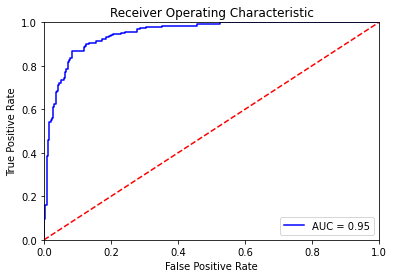

In [ ]:
evaluate_roc(probs, y_val)

The Bert Classifer achieves 0.95 AUC score and 88.89% accuracy rate on the validation set. This result is 10 points better than the baseline method. 

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# print(probs)
print(len(probs))
# Get predictions from the probabilities
threshold = 0.50
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))

# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())
# label
# non-rumour    393
# rumour        187

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
dict(zip(unique, counts))

In [ ]:
Corpus_pred_bert = Corpus_dev
print(Corpus_pred_bert.head())
# y_predicted = nb_model.predict(X_test_tfidf)
y_labels = ["non-rumour" if i==0 else "rumour" for i in preds]
# print(y_predicted,y_predicted_labels)
Corpus_pred_bert['label'] = y_labels
print(Corpus_pred_bert.head())
# Corpus_pred_bert.set_index('id',inplace=True)
dictt_bert = Corpus_pred_bert.to_dict()['label']
print(dictt_bert)
print(len(dictt_bert))

In [ ]:
with open("dev.baseline_bertF11.json", "w") as outfile: 
    json.dump(dictt_bert, outfile)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# print(probs)
print(len(probs))
# Get predictions from the probabilities
threshold = 0.55
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))

# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())
# label
# non-rumour    393
# rumour        187

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
dict(zip(unique, counts))

In [ ]:
Corpus_pred_bert = Corpus_test
print(Corpus_pred_bert.head())
# y_predicted = nb_model.predict(X_test_tfidf)
y_labels = ["non-rumour" if i==0 else "rumour" for i in preds]
# print(y_predicted,y_predicted_labels)
Corpus_pred_bert['label'] = y_labels
print(Corpus_pred_bert.head())
# Corpus_pred_bert.set_index('id',inplace=True)
dictt_bert = Corpus_pred_bert.to_dict()['label']
print(dictt_bert)
print(len(dictt_bert))

In [ ]:
with open("test.baseline_bertF1.json", "w") as outfile: 
    json.dump(dictt_bert, outfile)